# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## EDA

### Importing libraries

In [628]:
import pandas as pd
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [629]:
data_dir = Path('../assets/data/elections2022')
november_df = pd.read_csv(data_dir / '2021_11.csv', sep=';')
december_df = pd.read_csv(data_dir / '2021_12.csv', sep=';')
december_df.describe()

,pesquisa_id,ano,unidades_federativas_id,cargos_id,tipo_id,turno,instituto_id,cenario_id,candidatos_id,condicao,percentual,margem_mais,margem_menos,num_registro,orgao_registro,qtd_entrevistas,partidos_id,cidade
count,299.000000,299.0,299.0,299.0,299.0,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,0.0,0.0,299.000000,299.000000,0.0
mean,9761.675585,2022.0,6.0,3.0,2.0,1.434783,188.58194,24655.598662,1901.418060,0.341137,18.041137,2.408027,2.408027,NaN,NaN,2111.200669,16.956522,NaN
std,4.821488,0.0,0.0,0.0,0.0,0.496560,130.21952,30.562393,1890.381209,0.474886,17.174248,0.468543,0.468543,NaN,NaN,891.841771,16.514427,NaN
min,9755.000000,2022.0,6.0,3.0,2.0,1.000000,39.00000,24603.000000,209.000000,0.000000,0.000000,2.000000,2.000000,NaN,NaN,1000.000000,1.000000,NaN
25%,9758.000000,2022.0,6.0,3.0,2.0,1.000000,64.00000,24638.500000,706.000000,0.000000,3.000000,2.000000,2.000000,NaN,NaN,1200.000000,1.000000,NaN
50%,9761.000000,2022.0,6.0,3.0,2.0,1.000000,94.00000,24656.000000,973.000000,0.000000,10.000000,2.200000,2.200000,NaN,NaN,2002.000000,15.000000,NaN
75%,9766.000000,2022.0,6.0,3.0,2.0,2.000000,332.00000,24681.000000,1706.500000,1.000000,31.000000,3.000000,3.000000,NaN,NaN,3000.000000,33.000000,NaN
max,9769.000000,2022.0,6.0,3.0,2.0,2.000000,356.00000,24706.000000,6057.000000,1.000000,60.000000,3.200000,3.200000,NaN,NaN,3666.000000,62.000000,NaN


Lets filter our dataframe to have just the columns we will use.

In [630]:
columns_to_use = ["pesquisa_id", "cenario_id","turno", "partido", "candidato", "cenario_descricao", "instituto", "percentual", "data_referencia", "qtd_entrevistas"]
december_simple_df = december_df[columns_to_use].copy()
november_simple_df = november_df[columns_to_use].copy()

##### Getting invalid votes intentions (first turn).

Grouped by `pesquisa_id`, `cenario_id` and `turno == 1`

In [631]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido.isna())].head(20)

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas
0,9764,24661,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Datafolha,8.0,13-16.dez.2021,3666
33,9764,24662,1,NaN,branco / nulo / nenhum,cenário 2 - estimulado - 1º turno,Datafolha,8.0,13-16.dez.2021,3666
34,9764,24662,1,NaN,não sabe,cenário 2 - estimulado - 1º turno,Datafolha,2.0,13-16.dez.2021,3666
41,9764,24661,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,Datafolha,2.0,13-16.dez.2021,3666
48,9760,24647,1,NaN,nenhum / não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Futura,3.7,7-13.dez.2021,2000
50,9760,24647,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Futura,4.8,7-13.dez.2021,2000
62,9760,24648,1,NaN,não sabe / não respondeu,cenário 2 - estimulado - 1º turno,Futura,3.2,7-13.dez.2021,2000
63,9760,24648,1,NaN,branco / nulo,cenário 2 - estimulado - 1º turno,Futura,7.7,7-13.dez.2021,2000
65,9760,24649,1,NaN,nenhum / não sabe / não respondeu,cenário 3 - estimulado - 1º turno,Futura,2.4,7-13.dez.2021,2000
66,9760,24649,1,NaN,branco / nulo,cenário 3 - estimulado - 1º turno,Futura,4.6,7-13.dez.2021,2000


#### Lula vote intentions (first turn)


In [632]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido=="PT")].head(20)

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas
37,9764,24662,1,PT,Lula,cenário 2 - estimulado - 1º turno,Datafolha,47.0,13-16.dez.2021,3666
46,9764,24661,1,PT,Lula,cenário 1 - estimulado - 1º turno,Datafolha,48.0,13-16.dez.2021,3666
49,9760,24647,1,PT,Lula,cenário 1 - estimulado - 1º turno,Futura,37.9,7-13.dez.2021,2000
59,9760,24648,1,PT,Lula,cenário 2 - estimulado - 1º turno,Futura,39.4,7-13.dez.2021,2000
67,9760,24649,1,PT,Lula,cenário 3 - estimulado - 1º turno,Futura,42.4,7-13.dez.2021,2000
75,9760,24650,1,PT,Lula,cenário 4 - estimulado - 1º turno,Futura,43.8,7-13.dez.2021,2000
106,9758,24637,1,PT,Lula,cenário 2 - estimulado - 1º turno,Ideia Big Data,38.0,6-9.dez.2021,1200
110,9758,24638,1,PT,Lula,cenário 3 - estimulado - 1º turno,Ideia Big Data,38.0,6-9.dez.2021,1200
115,9758,24639,1,PT,Lula,cenário 4 - estimulado - 1º turno,Ideia Big Data,42.0,6-9.dez.2021,1200
128,9758,24636,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ideia Big Data,37.0,6-9.dez.2021,1200


### Add qtdy
$$qtd\_mencoes = (percentual * qtd\_entrevistas)\div 100.00$$

In [633]:
december_simple_df['qtd_mencoes'] = december_simple_df.percentual * december_simple_df.qtd_entrevistas / 100.0
november_simple_df['qtd_mencoes'] = november_simple_df.percentual * november_simple_df.qtd_entrevistas / 100.0


In [634]:
november_simple_df[(november_simple_df.turno==1) & (november_simple_df.partido.isna()) & (november_simple_df.cenario_descricao.str.startswith('cenário 1'))]

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,30.out-4.nov.2021,2000,240.000
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,30.out-4.nov.2021,2000,200.000
28,9749,24559,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Quaest,10.0,3-6.nov.2021,2063,206.300
29,9749,24559,1,NaN,indeciso,cenário 1 - estimulado - 1º turno,Quaest,4.0,3-6.nov.2021,2063,82.520
40,9751,24572,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Paraná Pesquisas,3.5,16-19.nov.2021,2020,70.700
41,9751,24572,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Paraná Pesquisas,9.9,16-19.nov.2021,2020,199.980
78,9753,24583,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Futura,4.0,16-20.nov.2021,2000,80.000
79,9753,24583,1,NaN,indeciso / não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Futura,3.6,16-20.nov.2021,2000,72.000
117,9752,24580,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,PoderData,3.0,22-24.nov.2021,2500,75.000
118,9752,24580,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,PoderData,6.0,22-24.nov.2021,2500,150.000


Prior Lula

In [635]:
november_simple_df[(november_simple_df.turno==1) & (november_simple_df.partido=="PT") & (november_simple_df.cenario_descricao.str.startswith('cenário 1'))]#.sum(axis=0)

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,30.out-4.nov.2021,2000,880.000
21,9749,24559,1,PT,Lula,cenário 1 - estimulado - 1º turno,Quaest,48.0,3-6.nov.2021,2063,990.240
42,9751,24572,1,PT,Lula,cenário 1 - estimulado - 1º turno,Paraná Pesquisas,34.9,16-19.nov.2021,2020,704.980
80,9753,24583,1,PT,Lula,cenário 1 - estimulado - 1º turno,Futura,38.6,16-20.nov.2021,2000,772.000
116,9752,24580,1,PT,Lula,cenário 1 - estimulado - 1º turno,PoderData,34.0,22-24.nov.2021,2500,850.000
134,9754,24593,1,PT,Lula,cenário 1 - estimulado - 1º turno,Atlas,42.8,27-29.nov.2021,4401,1883.628


Prior Brancos e Nulos

In [636]:
bn_df = november_simple_df[(november_simple_df.turno==1) & (november_simple_df.partido.isna()) & (november_simple_df.cenario_descricao.str.startswith('cenário 1'))]
bn_df.groupby(['cenario_id']).agg(bn=('qtd_mencoes', 'sum'), total=('qtd_entrevistas', 'max')).sum(axis=0)

bn        1517.332
total    14984.000
dtype: float64

Likelihood Lula

In [637]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido=="PT") & (december_simple_df.cenario_descricao.str.startswith('cenário 1'))]#.sum()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
46,9764,24661,1,PT,Lula,cenário 1 - estimulado - 1º turno,Datafolha,48.0,13-16.dez.2021,3666,1759.680
49,9760,24647,1,PT,Lula,cenário 1 - estimulado - 1º turno,Futura,37.9,7-13.dez.2021,2000,758.000
128,9758,24636,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ideia Big Data,37.0,6-9.dez.2021,1200,444.000
153,9761,24656,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ipec,48.0,9-13.dez.2021,2002,960.960
164,9769,24699,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ipespe,44.0,14-16.dez.2021,1000,440.000
208,9762,24658,1,PT,Lula,cenário 1 - estimulado - 1º turno,MDA,42.8,9-11.dez.2021,2002,856.856
218,9768,24692,1,PT,Lula,cenário 1 - estimulado - 1º turno,PoderData,40.0,19-21.dez.2021,3000,1200.000
270,9755,24603,1,PT,Lula,cenário 1 - estimulado - 1º turno,Quaest,47.0,2-5.dez.2021,2037,957.390


Likelihodd brancos e nulos

In [638]:
bn_df = december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido.isna()) & (december_simple_df.cenario_descricao.str.startswith('cenário 1'))]
bn_df.groupby(['cenario_id']).agg(bn=('qtd_mencoes', 'sum'), total=('qtd_entrevistas', 'max')).sum(axis=0)

bn        1953.256
total    16907.000
dtype: float64

## DEZEMBRO

In [674]:
# NOVEMBER
prior = pd.array([6049, 1508, 7382]).astype("float32")
# DECEMBER
observed = pd.array([7376, 1953, 7578])
                    
with pm.Model() as dirichlet_model:
        
    beta = pm.Beta("beta", alpha=4, beta=1)
    
    november_prior = pm.Dirichlet(
        "november_prior",
        # Lula, BrancosNulosNaoSabem, Demais candidatos
        a=prior * beta,
    )
    
    december_like = pm.Multinomial(
        "december_like", n=observed.sum(), p=november_prior, observed=observed,
    )
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [november_prior, beta]
Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 8 seconds.


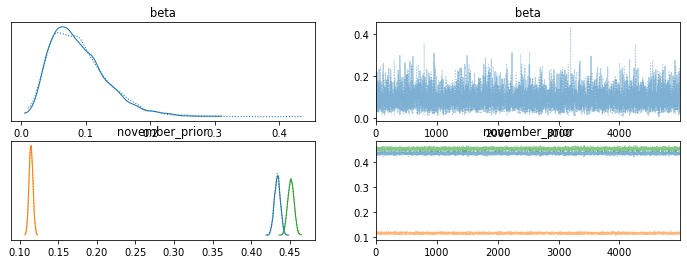

In [682]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=2, return_inferencedata=False, cores=2, progressbar=False) # 20K samples
   ppc = pm.sample_posterior_predictive(
        dirichlet_trace, random_seed=1777,
   )
   az.plot_trace(dirichlet_trace)

In [683]:
az.summary(dirichlet_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.090,0.045,0.021,0.173,0.001,0.0,6704.0,5864.0,1.0
november_prior[0],0.434,0.004,0.427,0.441,0.000,0.0,7173.0,7433.0,1.0
november_prior[1],0.114,0.002,0.110,0.119,0.000,0.0,5799.0,6259.0,1.0
november_prior[2],0.452,0.004,0.444,0.459,0.000,0.0,9209.0,7532.0,1.0


In [684]:
print(ppc)
ppc['december_like'].mean(axis=0)

{'december_like': array([[7283., 1951., 7673.],
       [7521., 1959., 7427.],
       [7336., 1838., 7733.],
       ...,
       [7349., 1912., 7646.],
       [7463., 1971., 7473.],
       [7353., 1852., 7702.]])}


array([7337.6116, 1935.8087, 7633.5797])

In [685]:
lula = ppc['december_like'][:, 0]
demais = ppc['december_like'][:, 2]
lula.shape,demais.shape

((10000,), (10000,))

In [686]:
(lula > demais).mean()

0.0456

# Verifica conjugado

In [797]:
# NOVEMBER
prior_data = pd.array([43, 11, 45]).astype("float32")
# DECEMBER
observed = pd.array([46, 12, 41])
                    
with pm.Model() as m:
        
    prior = pm.Dirichlet("prior", a=prior_data)
    
    pm.Multinomial("like", n=observed.sum(), p=prior, observed=observed)
    trace = pm.sample(5000, chains=2, return_inferencedata=True, cores=2, progressbar=False) # 20K samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8862164762208314, but should be close to 0.8. Try to increase the number of tuning steps.


In [798]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior[0],0.449,0.036,0.382,0.515,0.001,0.0,4583.0,5646.0,1.0
prior[1],0.116,0.024,0.074,0.161,0.000,0.0,3464.0,4123.0,1.0
prior[2],0.435,0.035,0.366,0.499,0.000,0.0,8576.0,7098.0,1.0


In [804]:
obs2 = prior_data + observed
with pm.Model() as m2:
        
    prior = pm.Dirichlet("prior", a=np.array([1.0, 1.0, 1.0]))
    
    pm.Multinomial("like", n=obs2.sum(), p=prior, observed=obs2)
    trace2 = pm.sample(5000, tune=2000, chains=2, return_inferencedata=True, cores=2, progressbar=False) # 20K samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 8 seconds.


In [805]:
az.summary(trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior[0],0.448,0.035,0.386,0.519,0.0,0.0,5262.0,6509.0,1.0
prior[1],0.120,0.024,0.078,0.166,0.0,0.0,3512.0,4645.0,1.0
prior[2],0.433,0.035,0.367,0.498,0.0,0.0,8094.0,7048.0,1.0


# Janeiro/Dezembro

4500


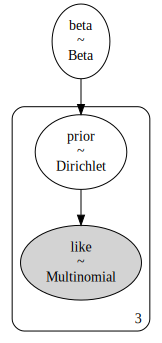

In [645]:
import numpy as np

T1 = 2_000 # 
T2 = 1_500 # EXAME/IDEIA
T3 = 1_000 # XP/IPESPE
# Mês atual: Lula, BrancosNulosNaoSabem, Demais candidatos
current_observed = np.array([1955, 535, 2010])

print(current_observed.sum())

december_data = np.array([7356, 1973, 7578]).astype("float32")

with pm.Model() as dirichlet_model:
    
    beta = pm.Beta("beta", alpha=6, beta=1)
    
    december_prior = pm.Dirichlet(
        "prior",
        # Mes anterior: Lula, BrancosNulosNaoSabem, Demais candidatos
        a = december_data * beta,
        # a = [1.0,1.0,1.0],
        shape=(3,),
    )
    
    january_like = pm.Multinomial(
        "like", n=current_observed.sum(), p=december_prior, observed=current_observed, shape=(3,)
    )
pm.model_to_graphviz(dirichlet_model)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior, beta]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning:

More chains (20000) than draws (3). Passed array should have shape (chains, draws, *shape)



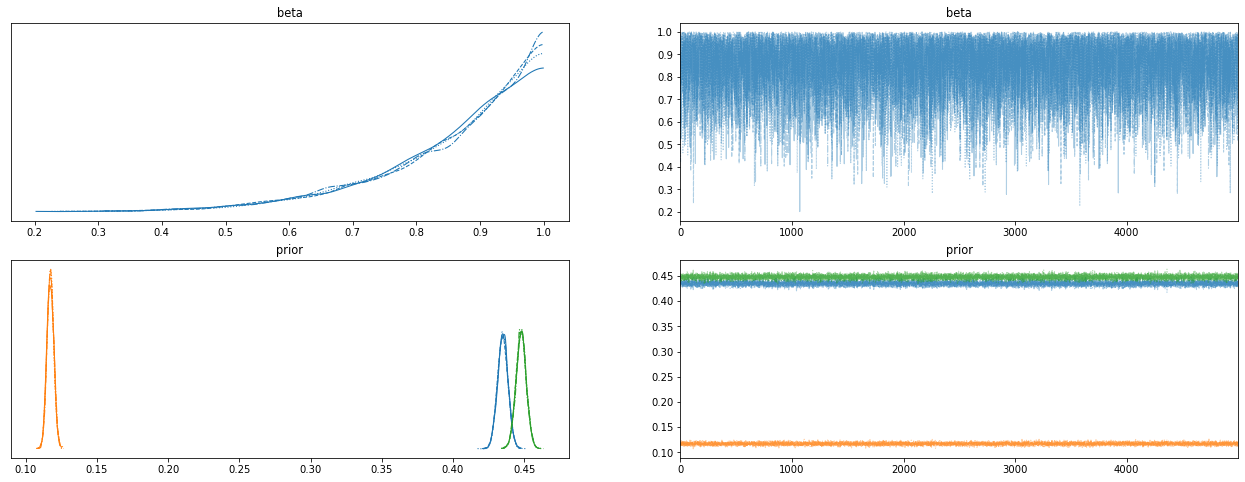

In [646]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=4, return_inferencedata=True, cores=4, progressbar=False) # 20K samples
   ppc = pm.sample_posterior_predictive(
        dirichlet_trace, random_seed=1777
   )
   az.plot_trace(dirichlet_trace, figsize=(22,8))
   dirichlet_trace.extend(az.from_dict(posterior_predictive=ppc))

In [647]:
az.summary(dirichlet_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.860,0.123,0.629,1.000,0.001,0.001,9788.0,7135.0,1.0
prior[0],0.435,0.004,0.428,0.442,0.000,0.000,12144.0,12470.0,1.0
prior[1],0.117,0.002,0.113,0.122,0.000,0.000,9056.0,11018.0,1.0
prior[2],0.448,0.004,0.441,0.455,0.000,0.000,21104.0,14977.0,1.0


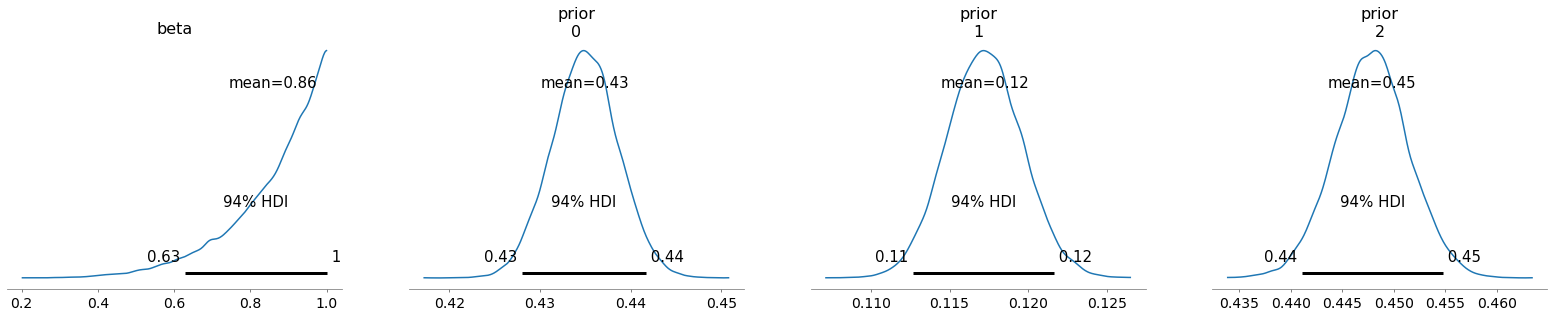

In [648]:
az.plot_posterior(dirichlet_trace);

<AxesSubplot:>

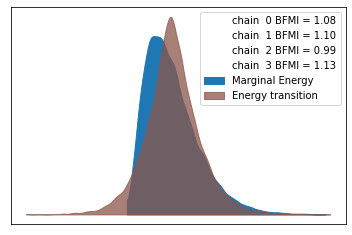

In [649]:
az.plot_energy(dirichlet_trace)

In [650]:
lula = ppc['like'][:, 0]
demais = ppc['like'][:, 2]
print(lula.shape,demais.shape)
prob_lula = (lula > demais).mean() * 100.0
print(f"Probabilidade de Lula vencer no primeiro turno é de: {prob_lula:.2f}%", )

(20000,) (20000,)
Probabilidade de Lula vencer no primeiro turno é de: 20.44%


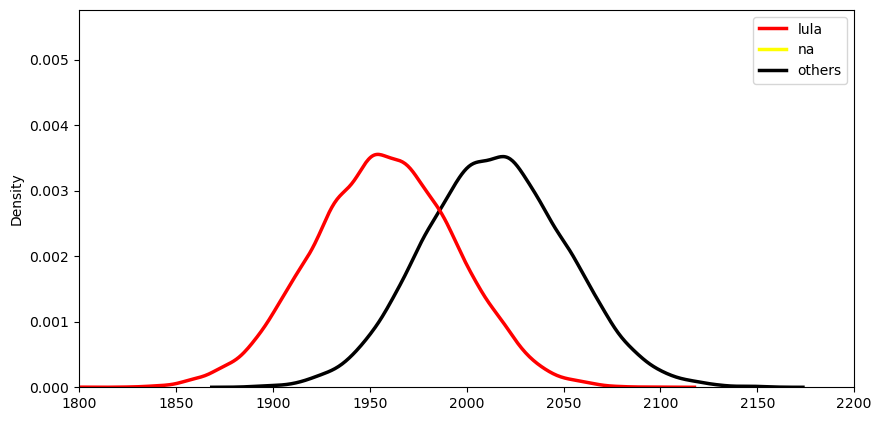

In [651]:
# create figure and axes
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.set_xlim(1800, 2200)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=500);

## Playground

In [652]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido.isna()) & (december_simple_df.cenario_descricao.str.startswith('cenário 1'))]

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
0,9764,24661,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Datafolha,8.0,13-16.dez.2021,3666,293.280
41,9764,24661,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,Datafolha,2.0,13-16.dez.2021,3666,73.320
48,9760,24647,1,NaN,nenhum / não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Futura,3.7,7-13.dez.2021,2000,74.000
50,9760,24647,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Futura,4.8,7-13.dez.2021,2000,96.000
137,9758,24636,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Ideia Big Data,10.0,6-9.dez.2021,1200,120.000
138,9758,24636,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,Ideia Big Data,3.0,6-9.dez.2021,1200,36.000
147,9761,24656,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Ipec,5.0,9-13.dez.2021,2002,100.100
148,9761,24656,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Ipec,9.0,9-13.dez.2021,2002,180.180
165,9769,24699,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Ipespe,3.0,14-16.dez.2021,1000,30.000
166,9769,24699,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Ipespe,9.0,14-16.dez.2021,1000,90.000


In [653]:
# probs = []
# for x in range(30):
#     with dirichlet_model:
#         dirichlet_trace = pm.sample(5000) # 100K samples
#         ppc = pm.sample_posterior_predictive(
#                 dirichlet_trace, random_seed=777,
#         )
#     lula = ppc['december_like'][:, 0]
#     demais = ppc['december_like'][:, 2]
#     probs.append((lula > demais).mean())

In [654]:
# pd.np.mean(probs), pd.np.std(probs)

In [655]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

0.32736042300928847

In [656]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [657]:
observed.sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [658]:
current_observed.sum(axis=0)

4500

In [659]:
current_observed.sum(axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
current_observed

array([[900, 240, 820],
       [615, 165, 705],
       [440, 130, 450]])

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [ ]:
# hide_input
# This cell is required for the export to HTML to work.


In [ ]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

[[0.42430116 0.11205287 0.46364597]
 [0.4776923  0.11859155 0.40371615]
 [0.45050595 0.11262034 0.43687371]
 [0.47414971 0.11459494 0.41125535]]


In [ ]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


0.43725
(4000, 3)


In [ ]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [ ]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

[1204.26642837 1206.35099961 1211.84649856 ... 1185.84604641 1170.43058971
 1190.83620722]
[557.10742899 615.26768416 604.12847455 636.30890986 509.46198724
 510.39745469 576.172482   533.9224985  525.35442508 839.95424655]
[604.13069908 549.45768248 567.06208182 531.7531662  642.75768124
 647.3309025  548.46293815 572.32042796 634.54905793 275.00691972]


In [ ]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

0.5245


In [ ]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [ ]:
dir2

array([[0.54970116, 0.02978016, 0.42051868],
       [0.54590152, 0.02934489, 0.4247536 ],
       [0.42624351, 0.0327602 , 0.54099629],
       ...,
       [0.47820177, 0.03428098, 0.48751725],
       [0.50005291, 0.02700324, 0.47294385],
       [0.49981088, 0.05089391, 0.44929521]])

In [ ]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

0.52225


In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.linspace(0,1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [666]:
x = np.arange(5,10)

In [668]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

array([ 0,  5,  6,  7,  8,  9, 14])

UsageError: Line magic function `%watermark` not found.
